In [1]:
%matplotlib inline  
from fastai.vision import *
from fastai.data_block import _maybe_squeeze
from fastai.callbacks import *
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from res2fg import *
from ranger import *


Mish activation loaded...


In [2]:
def strt_split(x, y, n_folds=10, random_seed = 42, path=Path('')):  
    try: 
        val_name = load('val_idx_10.joblib')
    except:
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
        val_name = [(val_idx, trn_idx) for trn_idx, val_idx in skf.split(x, y)]
        dump(val_name,'val_idx_10.joblib')
    return val_name

def modified_label_from_df(self, cols:IntsOrStrs=1, label_cls:Callable=None, **kwargs):
    "Label `self.items` from the values in `cols` in `self.inner_df`."
    self.inner_df.labels.fillna('', inplace=True)
    labels = self.inner_df.iloc[:,df_names_to_idx(cols, self.inner_df)]
    assert labels.isna().sum().sum() == 0, f"You have NaN values in column(s) {cols} of your dataframe, please fix it."
    if is_listy(cols) and len(cols) > 1 and (label_cls is None or label_cls == MultiCategoryList):
        new_kwargs,label_cls = dict(one_hot=True, classes= cols),MultiCategoryList
        kwargs = {**new_kwargs, **kwargs}
    return self._label_from_list(_maybe_squeeze(labels), label_cls=label_cls, **kwargs)


def flattenAnneal(learn:Learner, lr:float, n_epochs:int, start_pct:float, SUFFIX = 'PHASE_1_COS'):
    n = len(learn.data.train_dl)
    anneal_start = int(n*n_epochs*start_pct)
    anneal_end = int(n*n_epochs) - anneal_start
    phases = [TrainingPhase(anneal_start).schedule_hp('lr', lr),
             TrainingPhase(anneal_end).schedule_hp('lr', lr, anneal=annealing_cos)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    learn.callbacks.append(SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = f'{EXP_NAME}_{SUFFIX}'))
    learn.fit(n_epochs)

In [3]:
PATH = Path('..')
BS =            80
SZ =            512
FOLD =6
EXP_NAME =      f'NB_EXP_60_CV_{FOLD}_{SZ}'
IMG_TRAIN_224 = PATH/f'train_images_3chn_sasan'
IMG_TEST_224  = PATH/f'test_images_3chn_sasan'
DF_TRAIN =      pd.read_csv(PATH/'train_labels_as_strings.csv')
DF_SUBMI =      pd.read_csv(PATH/'stage_1_sample_submission.csv')



DF_SUBMI['fn'] = DF_SUBMI.ID.apply(lambda x: '_'.join(x.split('_')[:2]) + '.png')
DF_TRAIN['labels'].fillna('', inplace=True)
VAL_IDX = strt_split(DF_TRAIN['fn'], DF_TRAIN['labels'])[FOLD]

In [4]:
ItemList.label_from_df = modified_label_from_df
test_fns = DF_SUBMI.fn.unique()
tfms = get_transforms(max_rotate=180, flip_vert=True, max_zoom=1.4)

data = (ImageList.from_csv('..', 'train_labels_as_strings.csv', folder=IMG_TRAIN_224.name)
        .split_by_idxs(valid_idx=VAL_IDX[0], train_idx=VAL_IDX[1])
        .label_from_df(label_delim=' ')
        .transform(tfms = tfms,size=SZ)
        .add_test('../' +IMG_TEST_224.name + '/' + test_fns)
        .databunch(bs=BS)
        .normalize())

        

In [5]:
md_r2 = res2net(num_classes=data.c)

Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...


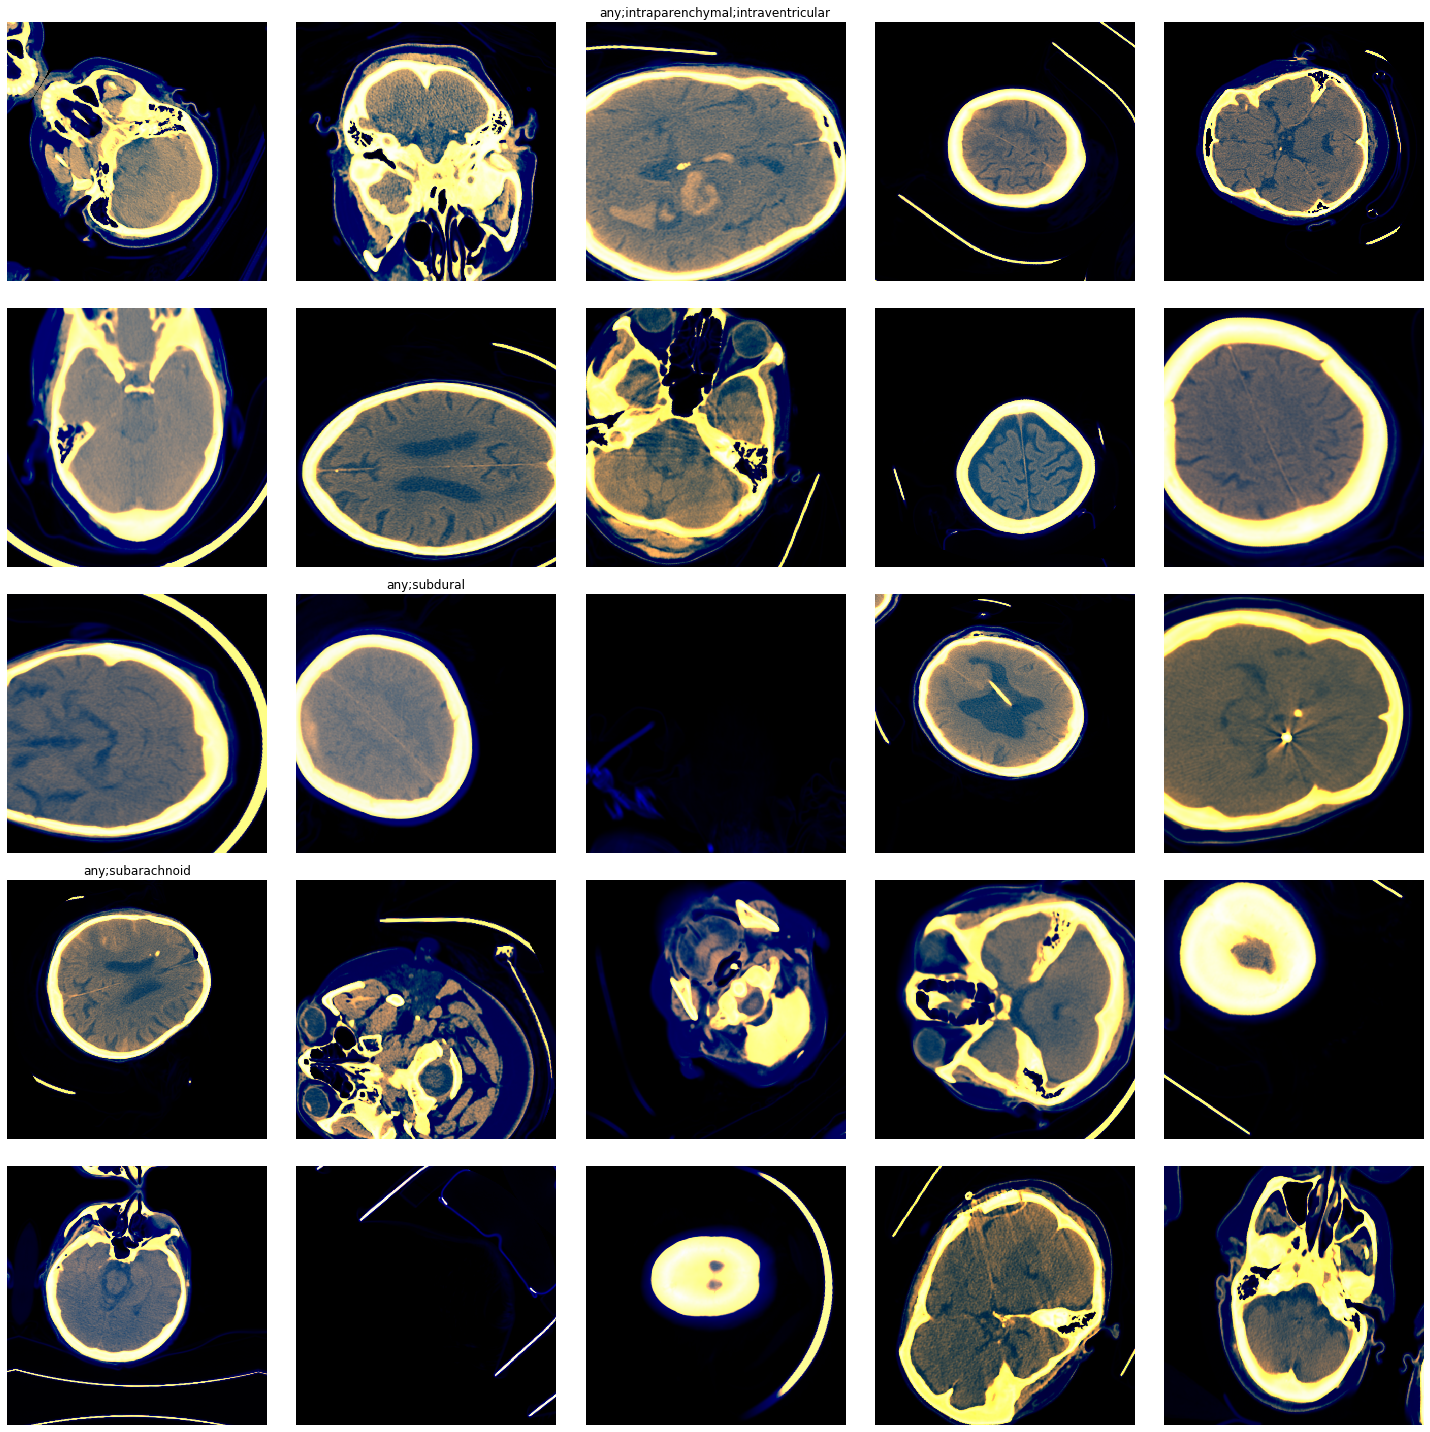

In [8]:
data.show_batch()

In [6]:
learn = Learner(data,
                md_r2,
                wd=1e-3,
                bn_wd=False, 
                true_wd=True, 
                metrics=[accuracy_thresh])

weights = [2, 1, 1, 1, 1, 1]
learn.loss_func  = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor(weights).cuda())
learn.model = nn.DataParallel(learn.model)
learn.load('NB_EXP_60_CV_6_224_PHASE_1_COS')
learn.to_fp16()
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


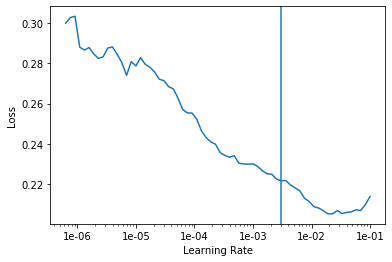

In [9]:
lr = 0.003
learn.recorder.plot()
plt.axvline(lr)

In [10]:
learn.unfreeze()
SUFFIX = 'FRZ'
learn.fit_one_cycle(3,
                    lr, 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = f'{EXP_NAME}_{SUFFIX}')])

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.102631,nan,0.972900,2:11:32


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4d7fce8950>
Traceback (most recent call last):
  File "/home/bukharih/anaconda3/envs/hb/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/bukharih/anaconda3/envs/hb/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/bukharih/anaconda3/envs/hb/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/bukharih/anaconda3/envs/hb/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/bukharih/anaconda3/envs/hb/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/bukharih/anaconda3/envs/hb/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-bc8dcfdc99a2>", line 5, in <module>
    callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = f'{EXP_NAME}_{SUFFIX}')])
  File "/home/bukharih/anaconda3/envs/hb/lib/python3.7/site-packages/fastai/train.py", line 23, in fit_one_cycle
    learn.fit(cyc_len, max_lr, wd=wd, callbacks=callbacks)
  File "/home/bukharih/anaconda3/envs/hb/lib/python3.7/site-packages/fastai/basic_train.py", line 200, in fit
    fit(epochs, self, metrics=self.metrics, callbacks=self.callbacks+callbacks)
  File "/home/bukharih/anaconda3/envs/hb/lib/python3.7/site-packages/fastai/basic_train.py", line 101, in fit
    loss = loss_batch(learn.model, xb, yb, learn.loss_func, learn.opt, cb_handler)
  File "/home/bukharih/anaconda3/envs/hb/lib/python

KeyboardInterrupt: 

In [ ]:
def get_preds(learn:Learner, sub_fn: str=f'{EXP_NAME}_PHASE_1_COS', TTA: bool = False, dt_type = DatasetType.Test):
    if TTA:
        learn.to_fp32()
        preds, targs = learn.TTA(ds_type=dt_type)
        sub_fn = f'{sub_fn}_TTA'
    else:
        preds, targs = learn.get_preds(dt_type)
    ids = []
    labels = []

    for fn, pred in zip(test_fns, preds):
        for i, label in enumerate(data.train_ds.classes):
            ids.append(f"{fn.split('.')[0]}_{label}")
            predicted_probability = '{0:1.10f}'.format(pred[i].item())
            labels.append(predicted_probability)
    pd.DataFrame({'ID': ids, 'Label': labels}).to_csv(f'{sub_fn}.csv', index=False)

In [ ]:
get_preds(learn)

In [ ]:
get_preds(learn, TTA=True)

In [ ]:
!sudo shutdown